# Timing Data

In [5]:
from time_solvers import timed_trials, plot_solver_run_times
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gillespy2 import StochKitSolver, NumPySSASolver, OptimizedSSASolver, SSACSolver, BasicTauLeapingSolver, BasicTauHybridSolver
from gillespy2.example_models import Example, Trichloroethylene, MichaelisMenten, Schlogl
#modelList = [Example(), Trichloroethylene(), MichaelisMenten(), Schlogl()]
modelList = [Example(),  MichaelisMenten(), Schlogl()]
solverList = [ StochKitSolver, NumPySSASolver, OptimizedSSASolver, SSACSolver, BasicTauLeapingSolver, BasicTauHybridSolver]

In [3]:
import os
if 'STOCHKIT_HOME' not in os.environ:
    os.environ['STOCHKIT_HOME'] = "/mnt/c/Users/seanm/OneDrive/Documents/Research/StochKit"
print( 'STOCHKIT_HOME =',os.environ['STOCHKIT_HOME'])

STOCHKIT_HOME = /home/drawert/research/StochKit/


In [4]:
trajectories = [2**i for i in range(11)]
timing_data = timed_trials(modelList, solverList, trajectories, number_trials=30,output_file='timing_data.pkl')

Model: Example, Solver: StochKitSolver, Trajectories: 1: 100%|██████████| 30/30 [00:00<00:00, 63.77it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 2: 100%|██████████| 30/30 [00:00<00:00, 66.67it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 4: 100%|██████████| 30/30 [00:00<00:00, 60.92it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 8: 100%|██████████| 30/30 [00:00<00:00, 51.96it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 16: 100%|██████████| 30/30 [00:00<00:00, 46.60it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 32: 100%|██████████| 30/30 [00:01<00:00, 29.67it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 64: 100%|██████████| 30/30 [00:01<00:00, 20.63it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 128: 100%|██████████| 30/30 [00:02<00:00, 13.38it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 256: 100%|██████████| 30/30 [00:04<00:00,  7.48it/s]
Model: Example, Solver: StochKitSolver, Trajecto

Model: Schlogl, Solver: NumPySSASolver, Trajectories: 2: 100%|██████████| 30/30 [00:00<00:00, 121.96it/s]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 4: 100%|██████████| 30/30 [00:00<00:00, 60.61it/s]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 8: 100%|██████████| 30/30 [00:00<00:00, 30.86it/s]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 16: 100%|██████████| 30/30 [00:01<00:00, 15.36it/s]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 32: 100%|██████████| 30/30 [00:03<00:00,  7.84it/s]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 64: 100%|██████████| 30/30 [00:07<00:00,  3.91it/s]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 128: 100%|██████████| 30/30 [00:15<00:00,  1.97it/s]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 256: 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 512: 100%|██████████| 30/30 [01:01<00:00,  2.04s/it]
Model: Schlogl, Solver: NumPySSASolver, Traje

In [4]:
#Ideally, we can run the timed tests once and save the results for later in a .pkl file
import pickle
with open('timing_data.pkl', 'rb') as f:
    timing_data = pickle.load(f)
    


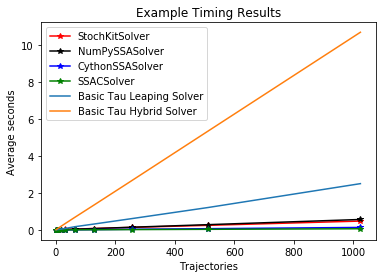

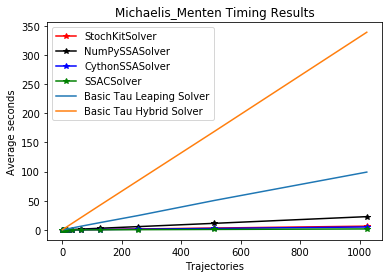

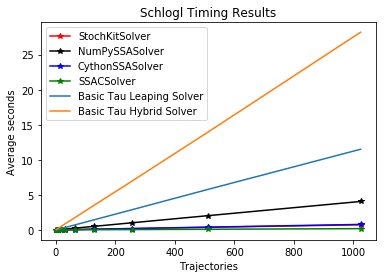

In [6]:
%matplotlib inline
styles = {
    'StochKitSolver' : 'r*-',
    'SSACSolver' : 'g*-',
    'CythonSSASolver' : 'b*-',
    'NumPySSASolver' : 'k*-',
    'BasicTauHybridSolver' : 'y*-',
    'BasicTauLeapingSolver' : 'm*-'
}
plot_solver_run_times(timing_data, line_styles=styles)

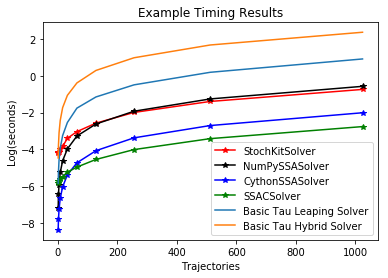

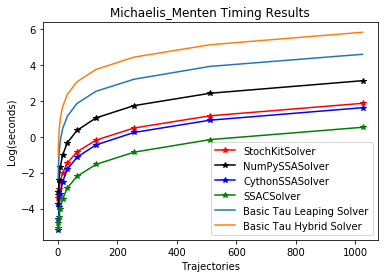

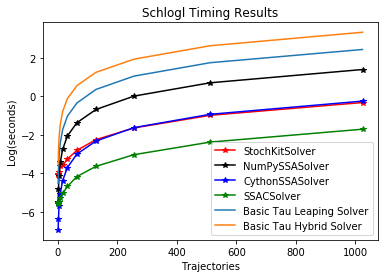

In [7]:
plot_solver_run_times(timing_data, line_styles=styles, ylabel='Log(seconds)', transformation=np.log)

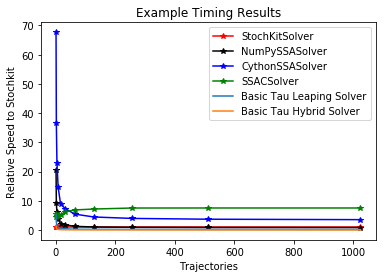

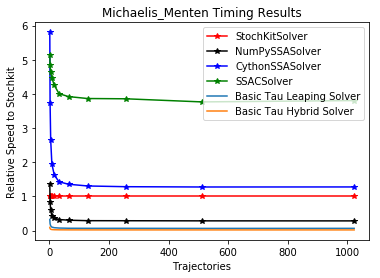

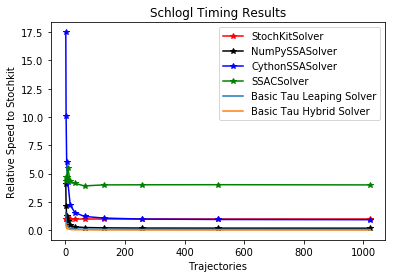

In [8]:
plot_solver_run_times(timing_data, line_styles=styles, ylabel='Relative Speed to Stochkit', baseline_solver_name=StochKitSolver.name)

In [9]:
import matplotlib.pyplot as plt
ylabel='Average run time (s)'
reduce=np.mean
line_styles=styles

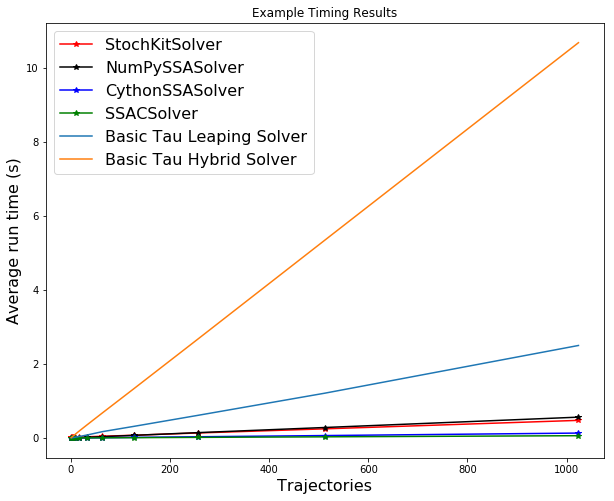

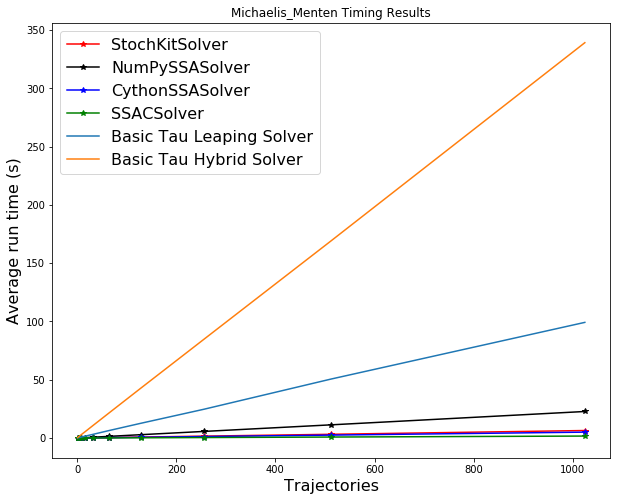

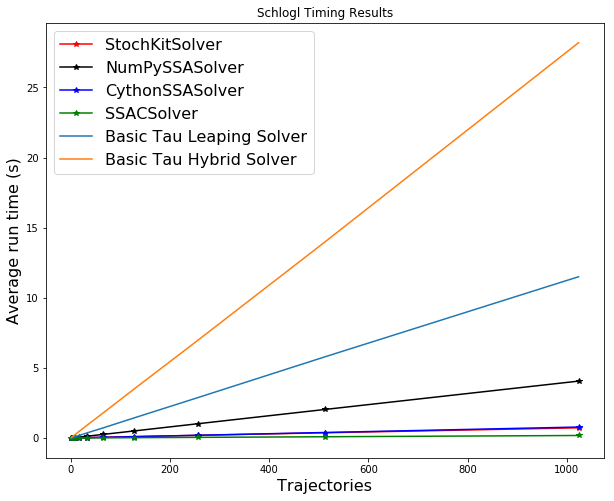

In [10]:
model_names = timing_data.keys()
for model in model_names:
    plt.figure(figsize=(10,8))
    plt.title('{} Timing Results'.format(model))
    plt.xlabel('Trajectories', fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    baseline = None
    #if baseline_solver_name is not None:
    #    baseline = reduce(timing_data[model][baseline_solver_name][:, 1:], axis=1)
    #    if transformation is not None:
    #        baseline = transformation(times)
    solver_names = timing_data[model].keys()
    for solver in solver_names:
        trajectories = timing_data[model][solver][:,0]
        times = reduce(timing_data[model][solver][:, 1:], axis=1)
        #if transformation is not None:
        #    times = transformation(times)
        #if baseline is not None:
        #    times = np.divide(baseline, times)
        if solver in line_styles:
            plt.plot(trajectories, times, line_styles[solver], label=solver)
        else:
            plt.plot(trajectories, times, label=solver)
    plt.legend(loc='best', fontsize=16)


In [6]:
timing_data.keys()

dict_keys(['Example', 'Michaelis_Menten', 'Schlogl'])

In [7]:
timing_data['Michaelis_Menten'].keys()

dict_keys(['StochKitSolver', 'NumPySSASolver', 'CythonSSASolver', 'SSACSolver', 'Basic Tau Leaping Solver', 'Basic Tau Hybrid Solver'])

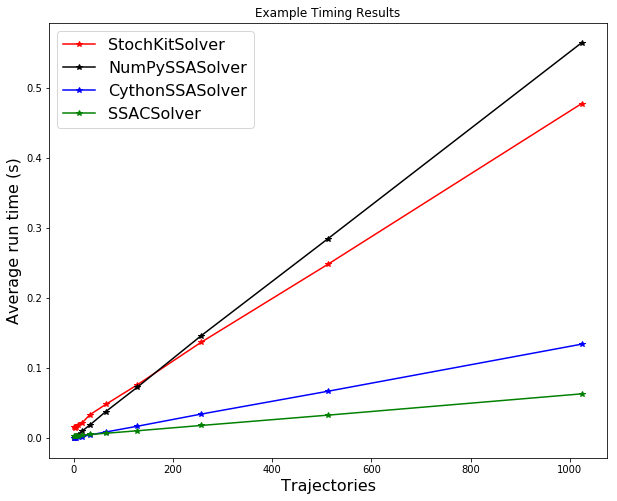

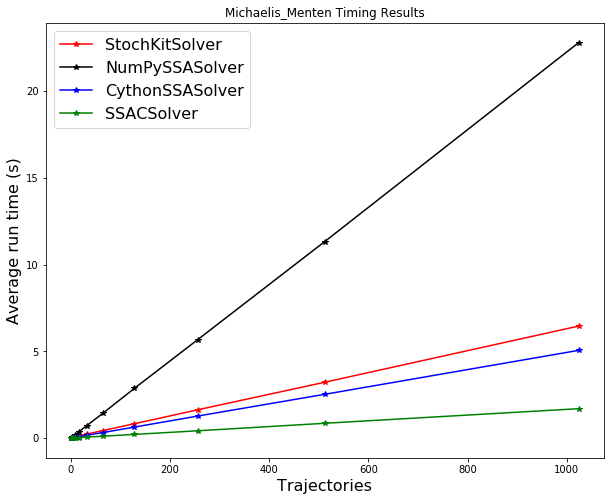

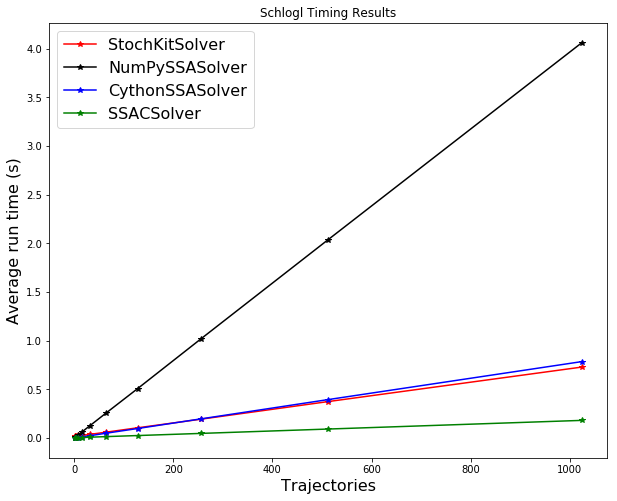

In [9]:
ylabel='Average run time (s)'
reduce=np.mean
line_styles={
    'StochKitSolver' : 'r*-',
    'SSACSolver' : 'g*-',
    'CythonSSASolver' : 'b*-',
    'NumPySSASolver' : 'k*-',
    'BasicTauHybridSolver' : 'y*-',
    'BasicTauLeapingSolver' : 'm*-'
}
model_names = timing_data.keys()
for model in model_names:
    plt.figure(figsize=(10,8))
    plt.title('{} Timing Results'.format(model))
    plt.xlabel('Trajectories', fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    baseline = None
    #if baseline_solver_name is not None:
    #    baseline = reduce(timing_data[model][baseline_solver_name][:, 1:], axis=1)
    #    if transformation is not None:
    #        baseline = transformation(times)
    #solver_names = timing_data[model].keys()
    solver_names = ['StochKitSolver', 'NumPySSASolver', 'CythonSSASolver', 'SSACSolver']
    for solver in solver_names:
        trajectories = timing_data[model][solver][:,0]
        times = reduce(timing_data[model][solver][:, 1:], axis=1)
        #if transformation is not None:
        #    times = transformation(times)
        #if baseline is not None:
        #    times = np.divide(baseline, times)
        if solver in line_styles:
            plt.plot(trajectories, times, line_styles[solver], label=solver)
        else:
            plt.plot(trajectories, times, label=solver)
    plt.legend(loc='best', fontsize=16)
